# Protein Wide Prediction
In this notebook we predict across whole proteins using the model trained
(exists in `preperation/models/`) on a running window.

We then layer different information gathered about NES on top of the predictions
and filter out the results based on that in order to reduce false positives

## Running inference

In [1]:
import sys, re
import numpy as np
import pandas as pd
import torch

# ─── IMPORT MODEL ───────────────────────────────────────────────────────────────
sys.path.insert(0, "../preperation")
from esm_embeddings import get_esm_model, get_esm_embeddings
from neural_net     import SimpleDenseNet, get_net_scores

# ─── CONFIG ────────────────────────────────────────────────────────────────────
WINDOW_SIZE       = 22
STEP              = 1
EMB_SIZE          = 1280
EMB_LAYER         = 33
TRAINED_MODEL_PTH = "../preperation/models/trained_layer_33.pth"
NESDB_CSV         = "../segmentation/data/NESDB_combined_database_unique_rows.csv"

# ─── LOAD DATA ─────────────────────────────────────────────────────────────────
df = pd.read_csv(NESDB_CSV)

# ─── LOAD MODELS ONCE ───────────────────────────────────────────────────────────
model_esm, alphabet, batch_converter, device = get_esm_model(embedding_size=EMB_SIZE)
net = SimpleDenseNet(esm_emb_dim=EMB_SIZE, hidden_dim=256, dropout=0.3)
net.load_state_dict(torch.load(TRAINED_MODEL_PTH))
model_esm.eval()
net.eval()

# ─── HELPER: GET SMOOTHED PROBS ─────────────────────────────────────────────────
import matplotlib.pyplot as plt  # for pd.Series rolling
def get_smoothed_probs(seq):
    pos = list(range(0, len(seq) - WINDOW_SIZE + 1, STEP))
    windows = [(str(i), seq[i:i+WINDOW_SIZE]) for i in pos]
    emb = get_esm_embeddings(
        windows, model_esm, alphabet, batch_converter, device,
        embedding_layer=EMB_LAYER, sequence_embedding=True
    )
    scores = get_net_scores(net, emb)
    probs = torch.sigmoid(torch.tensor(scores)).numpy()
    # smooth once here
    sm = pd.Series(probs).rolling(window=15, center=True, min_periods=1).mean().values
    return pos, sm

# ─── CACHE FOR ALL PROTEINS ────────────────────────────────────────────────────
# this runs the model only once
df["positions"], df["smoothed"] = zip(*df["Sequence"].map(get_smoothed_probs))
print("finished inference")


ESM model loaded to cuda
finish


## Cross referencing annotations:
- Exposed regions
- Helical regions
- Segment bounderies


Proteins in all three sources: 147
Basic (Point-wise): TP=2094, FP=12131, FN=48, precision=0.147, recall=0.978
+ Exposed and Helical (Point-wise): TP=1615, FP=8775, FN=82, precision=0.155, recall=0.952
+ In Segments (Point-wise): TP=1116, FP=5843, FN=88, precision=0.160, recall=0.927


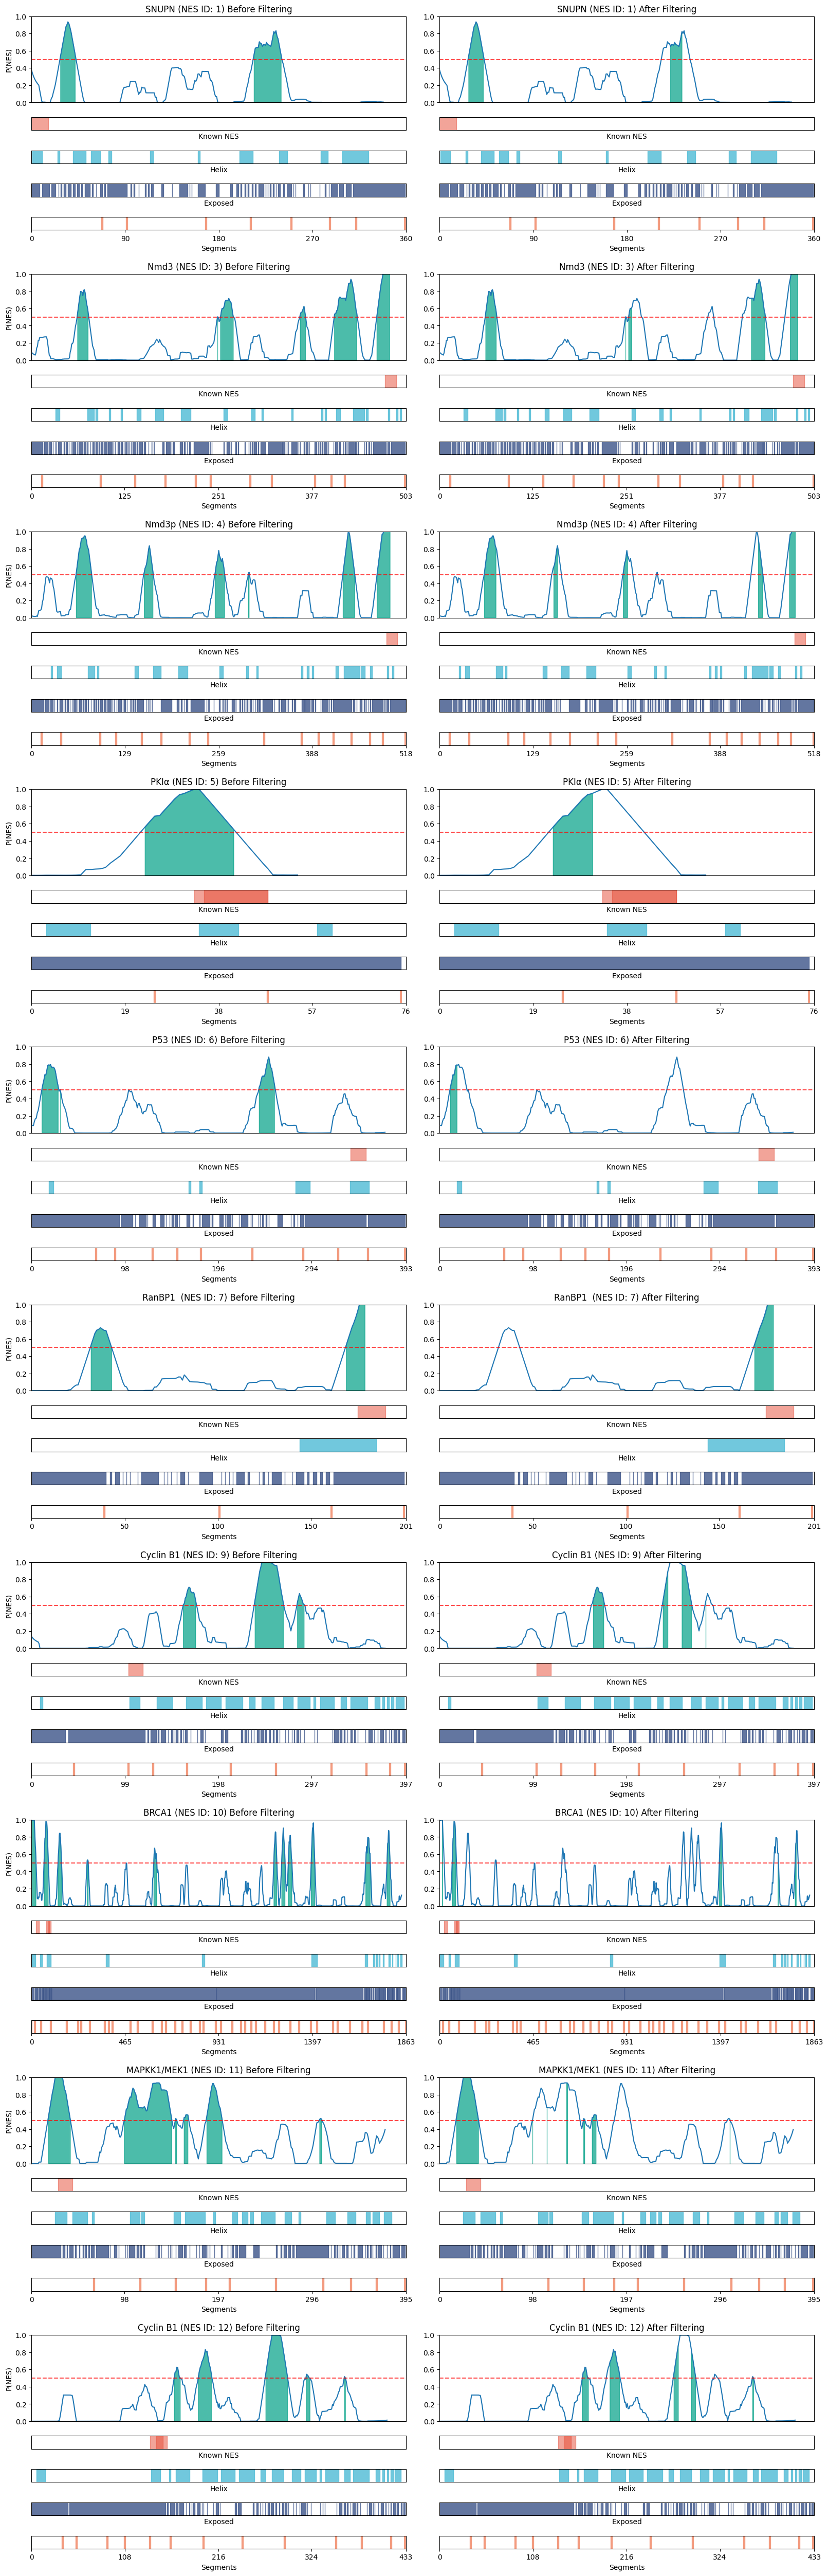

In [18]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ─── CONFIG ────────────────────────────────────────────────────────────────────
THRESHOLD      = 0.5
ANNOT_CSV      = "exposed_helical_extraction/data/residue_annotations.csv"
SEGMENT_TSV    = "../segmentation/data/ESM_NESDB_combined_segments.tsv"

# ─── LOAD DATA ─────────────────────────────────────────────────────────────────
# df, positions & smoothed already in memory from Cell 1
ann_df = pd.read_csv(ANNOT_CSV)
seg_df = pd.read_csv(SEGMENT_TSV, sep="\t", header=None, names=["uniprotID","segments"])

# ─── FILTER TO COMMON PROTEINS ─────────────────────────────────────────────────
set_df  = set(df["uniprotID"])
set_ann = set(ann_df["uniprot_id"])
set_seg = set(seg_df["uniprotID"])
common  = set_df & set_ann & set_seg
print(f"Proteins in all three sources: {len(common)}")

df = df[df["uniprotID"].isin(common)].reset_index(drop=True)

# ─── BUILD LOOKUP MAPS ──────────────────────────────────────────────────────────
# annotation map (only for common)
ann_map = {
    r["uniprot_id"]: {
        "helix":   np.array(list(r["helix"]),   dtype=int),
        "exposed": np.array(list(r["exposed"]), dtype=int)
    }
    for _, r in ann_df[ann_df["uniprot_id"].isin(common)].iterrows()
}

# parse TSV segments into lists of (start,end)
def parse_seg_ranges(s):
    pairs = re.findall(r"(\d+)[,\s]+(\d+)", str(s))
    return [(int(a),int(b)) for a,b in pairs]

seg_map = dict(zip(
    seg_df["uniprotID"].loc[seg_df["uniprotID"].isin(common)],
    seg_df["segments"].loc[seg_df["uniprotID"].isin(common)].apply(parse_seg_ranges)
))

# ─── UTILS ─────────────────────────────────────────────────────────────────────
def parse_ranges(rng_str):
    pairs = re.findall(r"(\d+)-(\d+)", str(rng_str))
    return [(int(a),int(b)) for a,b in pairs]

def overlap(a,b):
    s1,e1 = a; s2,e2 = b
    return not (e1 < s2 or e2 < s1)

# ─── MASK FUNCTIONS ────────────────────────────────────────────────────────────
def mask1(sm, pos, uid):
    return sm > THRESHOLD

def mask2(sm, pos, uid):
    hel = ann_map[uid]["helix"]
    exp = ann_map[uid]["exposed"]
    return np.array([
        (sm[i] > THRESHOLD)
        and hel[p:p+WINDOW_SIZE].sum() > 5
        and exp[p:p+WINDOW_SIZE].sum() > 5
        for i, p in enumerate(pos)
    ])

def mask3(sm, pos, uid):
    m2 = mask2(sm, pos, uid)
    segs = seg_map[uid]
    mask = []
    for i, ok in enumerate(m2):
        if not ok:
            mask.append(False)
            continue
        s = pos[i]; e = s + WINDOW_SIZE - 1
        length = WINDOW_SIZE
        # require ≥85% overlap with at least one seg
        good = False
        for ss, ee in segs:
            ol = min(e,ee) - max(s,ss) + 1
            if ol > 0 and (ol/length) >= 0.85:
                good = True
                break
        mask.append(good)
    return np.array(mask)

mask_fn_map = {"pred1": mask1, "pred2": mask2, "pred3": mask3}

# ─── CONFUSION & METRICS ───────────────────────────────────────────────────────
def segments_from_mask(pos, mask):
    segs, start, prev = [], None, None
    for p, ok in zip(pos, mask):
        if ok and start is None:
            # Start a new segment
            start = p
        elif not ok and start is not None:
            # End the current segment
            segs.append((start+1, prev+WINDOW_SIZE))
            start = None
        # Always update prev for active segments
        if ok:
            prev = p
    
    # Handle segment open at the end
    if start is not None:
        segs.append((start+1, prev+WINDOW_SIZE))
    
    # Merge overlapping segments
    if not segs:
        return []
        
    merged = [segs[0]]
    for current in segs[1:]:
        prev_start, prev_end = merged[-1]
        curr_start, curr_end = current
        
        if curr_start <= prev_end:
            # Merge overlapping segments
            merged[-1] = (prev_start, max(prev_end, curr_end))
        else:
            # Add non-overlapping segment
            merged.append(current)
            
    return merged

def compute_confusion(known, pred):
    tp = sum(1 for p in pred if any(overlap(p,k) for k in known))
    fp = len(pred) - tp
    fn = sum(1 for k in known if not any(overlap(k,p) for p in pred))
    return tp, fp, fn

def compute_confusion_pointwise(known, pos, mask, min_overlap=1):
    """
    Computes confusion matrix values by treating each predicted window as a point.
    A match is counted if the overlap between a predicted window and a known NES
    is greater than or equal to `min_overlap`.

    - TP: A predicted positive window that sufficiently overlaps with any known NES.
    - FP: A predicted positive window that does not sufficiently overlap with any known NES.
    - FN: A known NES that is not sufficiently overlapped by any predicted positive window.
    """
    tp = 0
    fp = 0
    
    # Helper to check for sufficient overlap
    def overlaps_enough(win1, win2):
        s1, e1 = win1
        s2, e2 = win2
        overlap_len = max(0, min(e1, e2) - max(s1, s2) + 1)
        return overlap_len >= min_overlap

    # Get all windows predicted as positive from the mask
    positive_windows = []
    for i, p in enumerate(pos):
        if mask[i]:
            # Convert 0-indexed position to 1-based window coordinates
            positive_windows.append((p + 1, p + WINDOW_SIZE))

    # Calculate True Positives and False Positives
    for pred_window in positive_windows:
        # A TP has sufficient overlap with at least one known NES
        if any(overlaps_enough(pred_window, k) for k in known):
            tp += 1
        else:
            fp += 1
            
    # Calculate False Negatives
    # A FN is a known NES that is not found by any positive prediction
    fn = sum(1 for k in known if not any(overlaps_enough(k, p) for p in positive_windows))
    
    return tp, fp, fn

# calculate and print metrics for each definition
for name, col in [("Basic", "pred1"), ("+ Exposed and Helical", "pred2"), ("+ In Segments", "pred3")]:
    tps = fps = fns = 0
    for _, row in df.iterrows():
        pos, sm = row["positions"], row["smoothed"]
        known = parse_ranges(row["start_end_ranges"])
        mask = mask_fn_map[col](sm, pos, row["uniprotID"])
        
        # New point-wise calculation (you can adjust min_overlap)
        tp, fp, fn = compute_confusion_pointwise(known, pos, mask, min_overlap=10)
        
        tps += tp; fps += fp; fns += fn
        
    prec = tps/(tps+fps) if tps+fps>0 else np.nan
    rec  = tps/(tps+fns) if tps+fns>0 else np.nan
    print(f"{name} (Point-wise): TP={tps}, FP={fps}, FN={fns}, precision={prec:.3f}, recall={rec:.3f}")
# ─── PLOTTING ─────────────────────────────────────────────────────────────────

plot_ids  = df["name"].head(10).tolist()
plot_uids = df["uniprotID"].head(10).tolist()
plot_seqs = df["Sequence"].head(10).tolist()
plot_known= df["start_end_ranges"].head(10).tolist()
blocks    = len(plot_ids)
height_ratios = [2, 0.3, 0.3, 0.3, 0.3] * blocks

fig, axes = plt.subplots(
    nrows=5*blocks, ncols=2, figsize=(16, 5*blocks),
    gridspec_kw={'height_ratios': height_ratios, 'hspace': 0.2}, constrained_layout=True
)
def plot_profiles(col, col_idx):
    for idx, (nid, uid, seq, krng) in enumerate(zip(plot_ids, plot_uids, plot_seqs, plot_known)):
        # col_idx = idx % 2
        row0 = idx *5
        ax1 = axes[row0    , col_idx]
        ax2 = axes[row0 + 1, col_idx]
        ax3 = axes[row0 + 2, col_idx]
        ax4 = axes[row0 + 3, col_idx]
        ax5 = axes[row0 + 4, col_idx]

        if col_idx == 0:
            ax1.set_ylabel("P(NES)")
        ax2.set_xlabel("Known NES")
        ax3.set_xlabel("Helix")
        ax4.set_xlabel("Exposed")
        ax5.set_xlabel("Segments")

        pos, sm = df.loc[df["name"] == nid, ["positions","smoothed"]].iloc[0]
        # a) NES probability + green mask
        ax1.plot(pos, sm)
        ax1.axhline(THRESHOLD, linestyle='--', color='red', alpha=0.7)
        mask = mask_fn_map[col](sm, pos, uid)
        ax1.fill_between(pos, 0, sm, where=mask, color='#00a087', alpha=0.7)
        title = nid + (" Before Filtering" if col_idx == 0 else " After Filtering")
        ax1.set_xlim(0, len(seq)); ax1.set_ylim(0,1); ax1.set_title(str(title)); ax1.set_xticks([])

        # b) Known NES
        kints = parse_ranges(krng)
        ax2.set_xlim(ax1.get_xlim()); ax2.set_ylim(0,1); ax2.set_yticks([])
        for s,e in kints:
            ax2.axvspan(s-1, e-1, color='#e64b35', alpha=0.5)
        ax2.set_xticks([])

        # c) Helix
        hel = ann_map[uid]["helix"]; xs = np.arange(len(hel))
        ax3.fill_between(xs, 0, hel, where=hel>0, step='mid', color='#4dbbd5', alpha=0.8)
        ax3.set_xlim(ax1.get_xlim()); ax3.set_ylim(0,1); ax3.set_yticks([]); ax3.set_xticks([])

        # d) Exposed
        exp = ann_map[uid]["exposed"]
        ax4.fill_between(xs, 0, exp, where=exp>0, step='mid', color='#3c5488', alpha=0.8)
        ax4.set_xlim(ax1.get_xlim()); ax4.set_ylim(0,1); ax4.set_yticks([]); ax4.set_xticks([])

        # e) Segments TSV
        segs = seg_map[uid]
        ax5.set_xlim(ax1.get_xlim())
        ax5.set_ylim(0, 1)
        ax5.set_yticks([])
        
        # Draw black ticks for each segment boundary
        for ss, ee in segs:
            ax5.axvline(x=ss-1, color='#f39b7f', linewidth=3)
            ax5.axvline(x=ee-1, color='#f39b7f', linewidth=3)
        
        ticks = np.linspace(*ax5.get_xlim(), num=5, dtype=int)
        ax5.set_xticks(ticks)
        ax5.set_xticklabels(ticks)


# draw all three
plot_profiles("pred1", 0 )
plot_profiles("pred3", 1)
plt.savefig("plots/cross_reference_results.png", dpi=300)
plt.show()


## Extract false positives

In [19]:
def get_false_positives(df, mask_fn, min_overlap=10):
    """
    Identifies and extracts false positive sequences based on a given mask.

    A false positive is a predicted positive window that does not sufficiently
    overlap with any known NES region.
    """
    fp_list = []

    # Helper to check for sufficient overlap
    def overlaps_enough(win1, win2):
        s1, e1 = win1
        s2, e2 = win2
        overlap_len = max(0, min(e1, e2) - max(s1, s2) + 1)
        return overlap_len >= min_overlap

    for _, row in df.iterrows():
        uid = row["uniprotID"]
        full_seq = row["Sequence"]
        pos, sm = row["positions"], row["smoothed"]
        known_nes = parse_ranges(row["start_end_ranges"])
        
        # Apply the specified mask to get predictions
        mask = mask_fn(sm, pos, uid)

        # Check each positively predicted window
        for i, p in enumerate(pos):
            if mask[i]:
                # Define the predicted window (1-based coordinates)
                pred_window = (p + 1, p + WINDOW_SIZE)
                
                # If it's not a True Positive, it's a False Positive
                is_tp = any(overlaps_enough(pred_window, k) for k in known_nes)
                if not is_tp:
                    start, end = pred_window
                    # Extract the sequence slice (Python uses 0-based indexing)
                    fp_sequence = full_seq[start-1:end]
                    
                    fp_list.append({
                        "uniprotID": uid,
                        "start": start,
                        "end": end,
                        "Sequence": fp_sequence
                    })
                    
    return pd.DataFrame(fp_list)

# --- How to use it in your notebook ---

# This will generate a DataFrame of FPs using the final, most restrictive mask.
fp_df = get_false_positives(df, mask3, min_overlap=10)
fp_df.head()

,uniprotID,start,end,Sequence
0,O95149,29,50,SQYKSKYSSLEQSERRRRLLEL
1,O95149,30,51,QYKSKYSSLEQSERRRRLLELQ
2,O95149,31,52,YKSKYSSLEQSERRRRLLELQK
3,O95149,32,53,KSKYSSLEQSERRRRLLELQKS
4,O95149,33,54,SKYSSLEQSERRRRLLELQKSK


In [21]:
fp_df.to_csv('data/false_positive_seqs.csv', index=False)